# Фотохостинг: подбор фотографий по описанию

## Введение

**Цель работы**  
Разработать модель, способную по описанию выполнить подобрать изображение.

**Задачи, решаемые в работе**  
1. Анализ предоставленного датасета для обучения и удаление фотографий, нарушающих законодательство.
2. Векторизация фотографий.
3. Векторизация текста.
4. Формирование и обучение модели.
5. Оценка качество модели.

**План работы:**  
1. Загрузить информацию о датасете.
2. Обработать оценки экспертов и крауда для определения совпадения фотографии и описания.
3. Удалить из обучающей выборке изображения, нарушающие законодательство.
4. Векторизовать изображения.
5. Векторизовать описания.
6. Сформировать несколько моделей и обучить их.
7. Оценить качество каждой модели и выбрать лучшую.
8. С помощью модели подобрать наиболее подходящее изображение по описанию.
9. Оценить визуально качество работы модели.


**Описание работы**

Модель необходима для фотохостинга для профессиональных фотографов «Со Смыслом» (“With Sense”).  

Пользователи размещают свои фотографии на хостинге и сопровождают их полным описанием: указывают место съёмок, модель камеры и т. д. Отличительная особенность сервиса — описание: его может предоставить не только тот, кто размещает фотографию, но и другие пользователи портала.  

В настоящий момент реализуется эксперимент по разработке поиска референсных фотографий для фотографов. Суть поиска заключается в следующем: пользователь сервиса вводит описание нужной сцены. Сервис выводит несколько фотографий с такой же или похожей сценой.  

Эксперимент необходимо защитить перед руководителем компании. Для защиты необходимо презентовать PoC (Proof of Concept, Проверка концепции). Для демонстрационной версии нужно выбрать лучшую  модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — и покажет, насколько текст и картинка подходят друг другу.
На основе лучшей модели можно будет собрать предварительную версию продукта.


**Юридические ограничения**  

В некоторых странах действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно, текстов, изображений, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16-ти лет. В связи с этим при подобных запросах должен показываться дисклеймер "This image is unavailable in your country in compliance with local laws".


**Описание данных**  

В файле train_dataset.csv находится информация, необходимая для обучения:
- имя файла изображения,
- идентификатор описания,
- текст описания.  

Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.  

В папке train_images содержатся изображения для тренировки модели.  

В файле CrowdAnnotations.tsv  — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- Доля людей, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание соответствует изображению.
- Количество человек, подтвердивших, что описание не соответствует изображению.  

В файле ExpertAnnotations.tsv  — данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:
- Имя файла изображения.
- Идентификатор описания.
- 3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.  

В файле test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат <имя файла изображения>#<порядковый номер описания>.  

В папке test_images содержатся изображения для тестирования модели.
При решении задачи используйте только один фреймворк  Pytorch или Keras.

## Загрузка библиотек и функций

### Библиотеки

In [ ]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.6 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostRegressor
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tensorflow
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import torch
from torchvision import models as torch_models
from torchvision import transforms
from transformers import AutoModel, AutoTokenizer
from transformers import BertModel, BertTokenizer
from tqdm import tqdm
from xgboost import XGBRegressor
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor

/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


### Функции

In [ ]:
# Функция очистки текста
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    return text

## Загрузка файлов

Укажите пути файлов:

In [ ]:
!wget -q https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -q dsplus_integrated_project_4.zip

DATA_PATH = '/content/to_upload'

In [ ]:
train_dataset = '' # Пожалуйста, укажите здесь пути файлов
test_queries = ''
test_images = ''
crowd_annot = ''
expert_annot = ''
# Пути к папке с изображениями
image_folder_train = ''
image_folder_test = ''

In [ ]:
if train_dataset == '':
  from google.colab import drive
  drive.mount('/content/drive')
  train_dataset = '/content/to_upload/train_dataset.csv'
  test_queries = '/content/to_upload/test_queries.csv'
  test_images = '/content/to_upload/test_images.csv'
  crowd_annot = '/content/to_upload/CrowdAnnotations.tsv'
  expert_annot = '/content/to_upload/ExpertAnnotations.tsv'
  image_folder_train = '/content/to_upload/train_images'
  image_folder_test = '/content/to_upload/test_images'

Mounted at /content/drive


In [ ]:
dataframes = {}

try:
    dataframes['train_dataset'] = pd.read_csv(train_dataset)
    dataframes['test_queries'] = pd.read_csv(test_queries, sep='|')
    dataframes['test_images'] = pd.read_csv(test_images)
    dataframes['crowd_annot'] = pd.read_table(crowd_annot, names=['image_name', 'image_describe', 'frac_people', 'num_positive', 'num_negotive'])
    dataframes['expert_annot'] = pd.read_table(expert_annot, names=['image_name', 'image_describe', 'exp_1', 'exp_2', 'exp_3'])
except FileNotFoundError as e:
    print(f'Проверьте пути расположения файлов. Ошибка: {e}')
else:
    train_dataset = dataframes['train_dataset']
    test_queries = dataframes['test_queries']
    test_images = dataframes['test_images']
    crowd_annot = dataframes['crowd_annot']
    expert_annot = dataframes['expert_annot']
    print("Все файлы успешно загружены")

Все файлы успешно загружены


In [ ]:
test_images = dataframes['test_images']

Посмотрим на загруженные файлы

In [ ]:
for key, df in dataframes.items():
    print(f"Название датафрейма: {key}")
    print("\nИнформация о датафрейме:")
    print(df.info())
    print("\nПервые 5 строк датафрейма:")
    print(df.head())
    print("\n" + "="*50 + "\n")

Название датафрейма: train_dataset

Информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

Первые 5 строк датафрейма:
                       image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearin

#### Уникальные изображения:

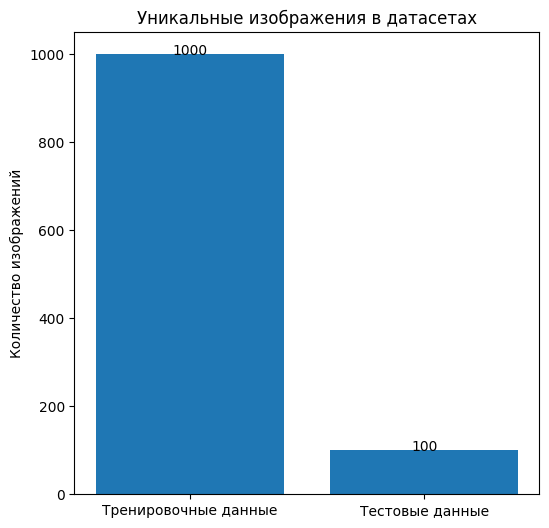

In [ ]:
plt.figure(figsize=(6, 6))
values = [len(train_dataset['image'].unique()), len(test_images['image'].unique())]
labels = ['Тренировочные данные', 'Тестовые данные']

plt.bar(labels, values)
plt.ylabel('Количество изображений')
plt.title('Уникальные изображения в датасетах')

for i in range(len(values)):
    plt.text(i, values[i], str(values[i]), ha='center')

plt.show()

В тренировочном датасете у нас 1000 уникальных изображений, в тестовом - 100. Соотношение 10/1.

#### Уникальные запросы

Посмотрим теперь на количество запросов в тестовом и тренировочном

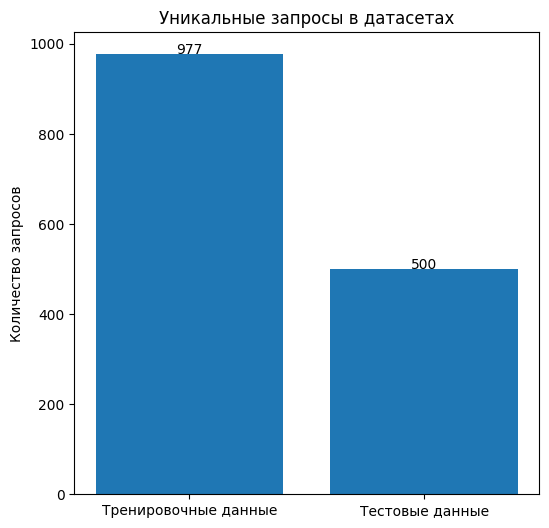

In [ ]:
plt.figure(figsize=(6, 6))
values = [len(train_dataset['query_text'].unique()), len(test_queries['query_text'].unique())]
labels = ['Тренировочные данные', 'Тестовые данные']

plt.bar(labels, values)
plt.ylabel('Количество запросов')
plt.title('Уникальные запросы в датасетах')

for i in range(len(values)):
    plt.text(i, values[i], str(values[i]), ha='center')

plt.show()

Запросов в тренировочных данные в два раза больше, чем в тестовом. Также интересное наблюдение. В тренировочном датасете уникальных запросов меньше, чем уникальных картинок. Значит, к 23 изображениям одинаковые подписи.

#### Оценки в датасетах

Теперь посмотрим на количество оценок крауда и эксперта.

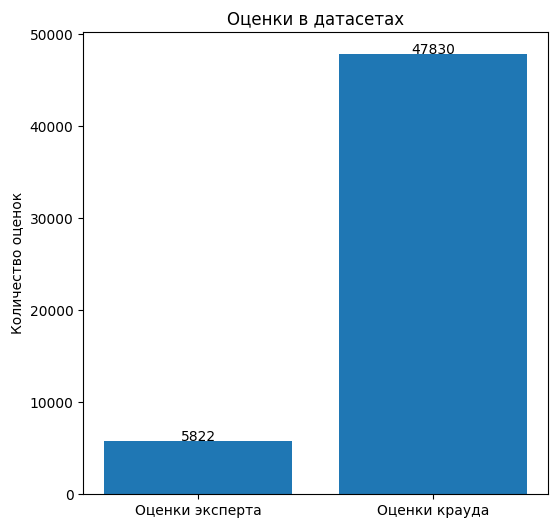

In [ ]:
plt.figure(figsize=(6, 6))
values = [len(expert_annot), len(crowd_annot)]
labels = ['Оценки эксперта', 'Оценки крауда']

plt.bar(labels, values)
plt.ylabel('Количество оценок')
plt.title('Оценки в датасетах')

for i in range(len(values)):
    plt.text(i, values[i], str(values[i]), ha='center')

plt.show()

Как видно, оценок крауда почти в 10 раз больше. Посмотрим на распределения оценок.

Оценки экспертов

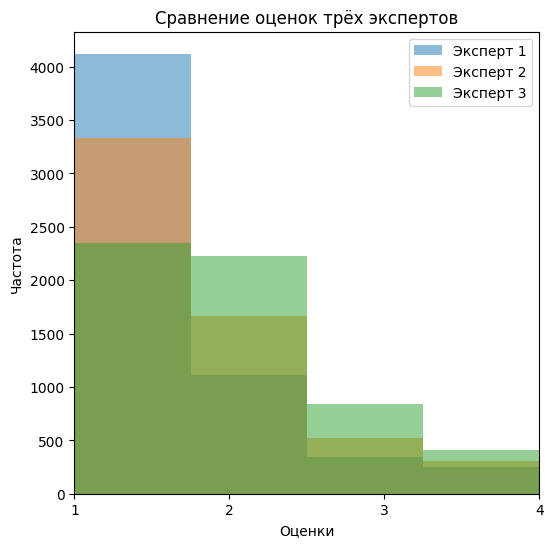

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(expert_annot['exp_1'], bins=4, alpha=0.5, label='Эксперт 1')
plt.hist(expert_annot['exp_2'], bins=4, alpha=0.5, label='Эксперт 2')
plt.hist(expert_annot['exp_3'], bins=4, alpha=0.5, label='Эксперт 3')

plt.legend()
plt.title('Сравнение оценок трёх экспертов')
plt.xlabel('Оценки')
plt.ylabel('Частота')
plt.xlim(1, 4)
plt.xticks(range(1, 5, 1))
plt.show()

Эксперты чаще всего ставили оценку 1, что логично, ведь в датасете около 6000 изображений, из которых только 1000 уникальных и имеют уникальные подписи. Также видно что эксперт 3 чаще других ставит оценки 2, 3, и 4. Чаще всего оценку 1 ставить эксперт 1.

Теперь посмотрим на оценки крауда

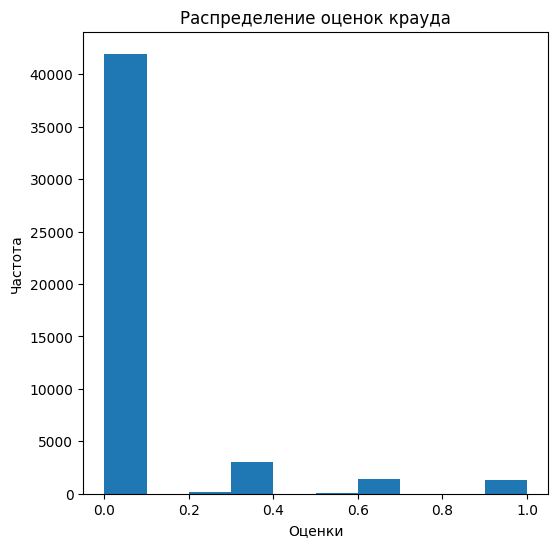

In [ ]:
plt.figure(figsize=(6, 6))
plt.hist(crowd_annot['frac_people'], bins=10)
plt.title('Распределение оценок крауда')
plt.xlabel('Оценки')
plt.ylabel('Частота')
plt.show()

Как видно, оценки крауда тоже чаще всего находятся в районе полного несоответствия картинок и описания.

#### Сравнение совпадающих пар

Сравним, сколько пар изображение - описание совпадает в тестовом датасете, а сколько нет.

In [ ]:
test_queries['clean_query_id'] = test_queries['query_id'].str.split('#').str[0]

matches = test_queries['image'] == test_queries['clean_query_id']

matching_pairs = matches.sum()
non_matching_pairs = len(test_queries) - matching_pairs

print(f"Количество совпадающих пар: {matching_pairs}")
print(f"Количество несовпадающих пар: {non_matching_pairs}")
print(f"Всего пар: {len(test_queries)}")
print(f"Процент совпадений: {(matching_pairs/len(test_queries)*100):.2f}%")

Количество совпадающих пар: 500
Количество несовпадающих пар: 0
Всего пар: 500
Процент совпадений: 100.00%


Как видно, все пары в тестовом датасете совпадают.

In [ ]:
test_queries = test_queries.drop('clean_query_id', axis=1) # удаление служебного столбца

#### Примеры изображений из датасетов

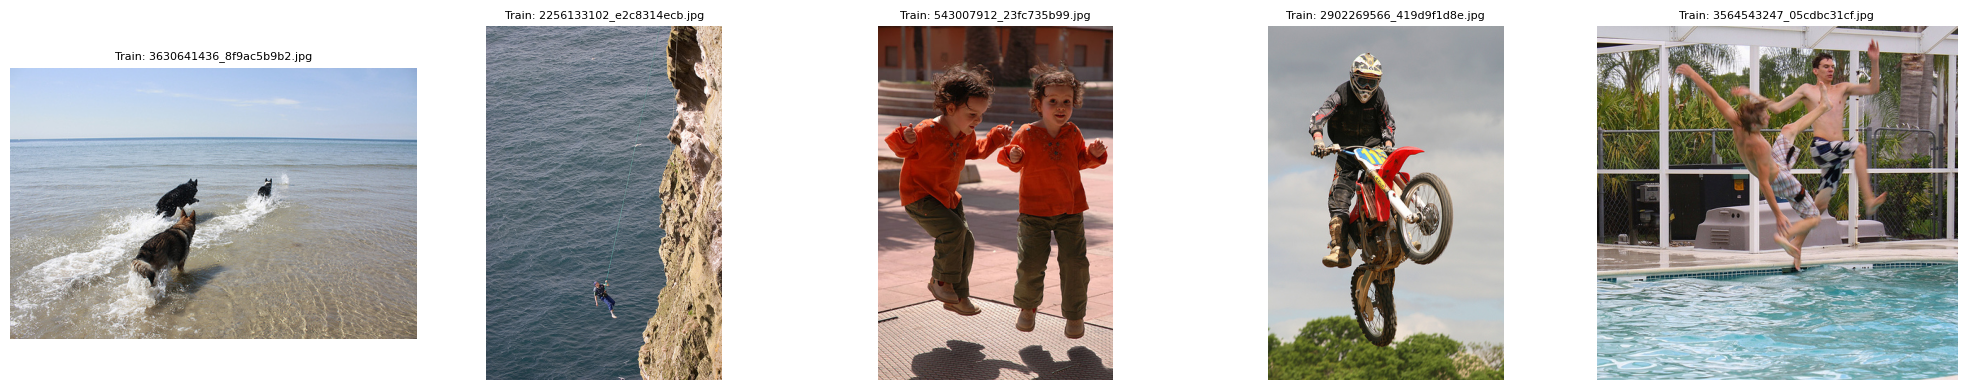

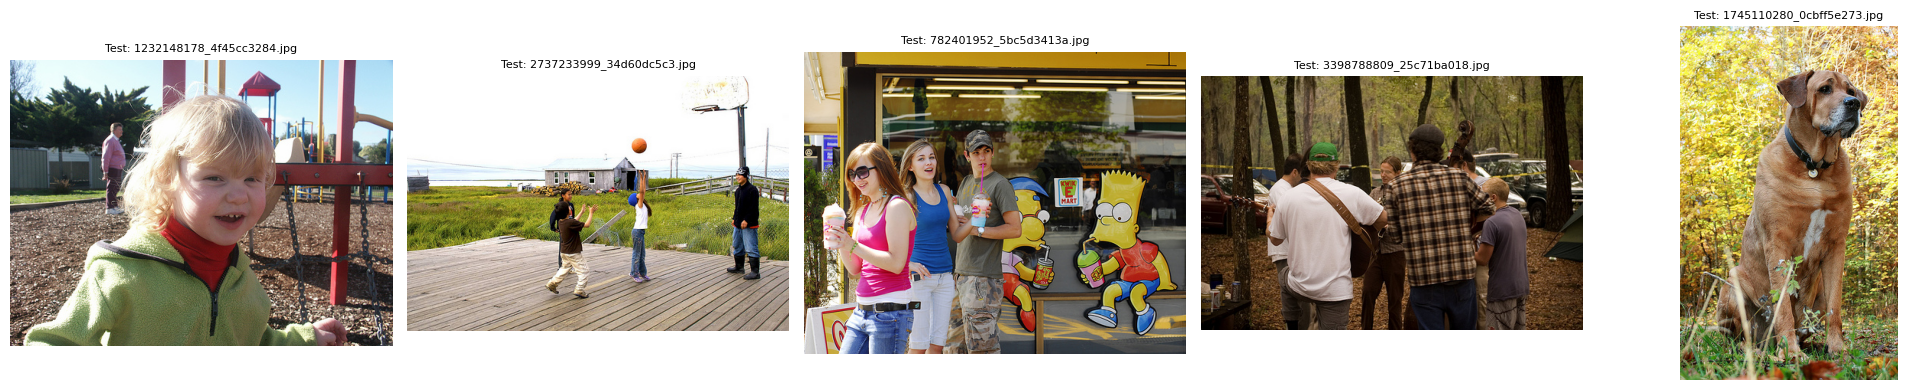

In [ ]:
train_images = os.listdir(image_folder_train)
test_images_sample = os.listdir(image_folder_test)

plt.figure(figsize=(20, 4))

# 5 изображений из тренировочной папки
for i, img_name in enumerate(train_images[:5]):
    plt.subplot(1, 5, i+1)
    img = Image.open(os.path.join(image_folder_train, img_name))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Train: {img_name}', size=8)

plt.tight_layout()
plt.show()

# 5 изображений из тестовой папки
plt.figure(figsize=(20, 4))
for i, img_name in enumerate(test_images_sample[:5]):
    plt.subplot(1, 5, i+1)
    img = Image.open(os.path.join(image_folder_test, img_name))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Test: {img_name}', size=8)

plt.tight_layout()
plt.show()

Примеры картинок показывают, что обоих датасетах есть немаленькое количество изображений с детьми, если даже при предварительном просмотре попало 4 картинки из 10.

**Итоги обзора данных:**
1. В обучающей выборке почти 6000 изображений.
2. В тестовом датасете их 500. При этом в файле test image представлено всего 100 наименований
3. В файле с аннотациями крауда почти 48 тысяч записей, что значительно больше, чем изображений.
4. В файле с аннотациями экспертов количество строк совпадает с количеством изображений.
5. Заголовков нет ни в аннотациях крауда, ни в аннотациях экспертов. Их добавили при загрузке данных.
6. Пропусков значений нет.
7. Пары в тестовом датасете совпадают.
8. В данных большое количество картинок с детьми.

## Обработка оценок экспертов и крауда

Для формирования оценки экспертов воспользуемся медианой

In [ ]:
expert_annot['median_score'] = expert_annot[['exp_1', 'exp_2', 'exp_3']].median(axis=1)

Переведем в десятичные дроби (выведем вероятность):

In [ ]:
expert_annot['median_score'] = round((expert_annot['median_score'] - 1) / (4 - 1),1)

In [ ]:
expert_annot.head()

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score  
0      1           0.0  
1      2           0.0  
2      2           0.0  
3      2           0.3  
4      2           0.0

Оценки добавлены. Теперь соберем общий датафрейм с оценками крауда и экспертов.

In [ ]:
total_annot = expert_annot.merge(crowd_annot, on=['image_name','image_describe'], how='left')

Соберем общую оценку. Оценке экспертам присвоим вес 0,7, а оценке крауда 0,3.

In [ ]:
total_annot['total_score'] = total_annot['median_score'] * 0.7 + total_annot['frac_people']*0.3

In [ ]:
total_annot.head()

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score  frac_people  num_positive  num_negotive  total_score  
0      1           0.0          0.0           0.0           3.0          0.0  
1      2           0.0          0.0           0.0           3.0          0.0  
2      2           0.0          NaN           NaN           NaN          NaN  
3      2           0.3          NaN           NaN           NaN          NaN  
4      2           0.0          NaN           NaN           NaN          NaN

In [ ]:
total_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      5822 non-null   object 
 1   image_describe  5822 non-null   object 
 2   exp_1           5822 non-null   int64  
 3   exp_2           5822 non-null   int64  
 4   exp_3           5822 non-null   int64  
 5   median_score    5822 non-null   float64
 6   frac_people     2329 non-null   float64
 7   num_positive    2329 non-null   float64
 8   num_negotive    2329 non-null   float64
 9   total_score     2329 non-null   float64
dtypes: float64(5), int64(3), object(2)
memory usage: 455.0+ KB


Общая оценка получена.

Так как у нас получается много пропусков при слиянии таблиц, что указывает на отсутствует оценок крауда по некоторым изображением, не будем учитывать оценки крауда. Для этого необходимо отрезать лишние столбцы.


In [ ]:
total_annot = total_annot.drop(['frac_people', 'num_positive', 'num_negotive', 'total_score'], axis=1)

In [ ]:
total_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   image_name      5822 non-null   object 
 1   image_describe  5822 non-null   object 
 2   exp_1           5822 non-null   int64  
 3   exp_2           5822 non-null   int64  
 4   exp_3           5822 non-null   int64  
 5   median_score    5822 non-null   float64
dtypes: float64(1), int64(3), object(2)
memory usage: 273.0+ KB


Итог: оценка добавлена, пустые строки удалены.

### Исключение картинок с некорректным содержанием

Добавим в общий датафрейм описание картинок

In [ ]:
total_annot.head()

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score  
0      1           0.0  
1      2           0.0  
2      2           0.0  
3      2           0.3  
4      2           0.0

In [ ]:
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...

In [ ]:
total_annot = total_annot.merge(train_dataset.drop('image', axis=1), left_on=total_annot['image_describe'] + total_annot['image_name'],
                                right_on=train_dataset['query_id'] + train_dataset['image'],
                                how='inner')

In [ ]:
total_annot.head()

key_0  \
0  2549968784_39bfbe44f9.jpg#21056338697_4f7d7ce2...   
1  2718495608_d8533e3ac5.jpg#21056338697_4f7d7ce2...   
2  3181701312_70a379ab6e.jpg#21056338697_4f7d7ce2...   
3  3207358897_bfa61fa3c6.jpg#21056338697_4f7d7ce2...   
4  3286822339_5535af6b93.jpg#21056338697_4f7d7ce2...   

                  image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score                     query_id  \
0      1           0.0  2549968784_39bfbe44f9.jpg#2   
1      2           0.0  2718495608_d8533e3ac5.jpg#2   
2      2           0.0  3181701312_70a379ab6e.jpg#2   
3      2           0.3  3207358897_bfa61fa3c6.jpg#2   
4      2           0.0  3286822339_5535af6b93.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

In [ ]:
total_annot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key_0           5822 non-null   object 
 1   image_name      5822 non-null   object 
 2   image_describe  5822 non-null   object 
 3   exp_1           5822 non-null   int64  
 4   exp_2           5822 non-null   int64  
 5   exp_3           5822 non-null   int64  
 6   median_score    5822 non-null   float64
 7   query_id        5822 non-null   object 
 8   query_text      5822 non-null   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 409.5+ KB


In [ ]:
total_annot = total_annot.drop('key_0', axis=1) # Удаление технического столбца

Сформируем список нежелательных ключевых слов.

In [ ]:
child_list = [
    'boy',
    'child',
    'children',
    'kid',
    'kids',
    'girl',
    'girls',
    'teen',
    'teenage',
    'teenager',
    'adolescent',
    'youth',
    'young',
    'minor',
    'underage',
    'juvenile',
    'baby',
    'infant',
    'toddler',
    'school-age',
    'pupil',
    'student',
    'schoolchild'
]

Создаем паттерн из этих слов и оставляем только те строки, где есть эти слова.

In [ ]:
pattern = '|'.join(child_list)

df_forbidden = train_dataset[train_dataset['query_text'].str.contains(pattern, case=False, na=False)]

Теперь формируем перечень картинок с запрещенным контентом

In [ ]:
forbidden_image = df_forbidden['query_id'].unique()

Отрезаем лишнее #2

In [ ]:
forbidden_image = [x.split('#')[0] for x in forbidden_image]

Теперь оставим в датафрейме только картинки, которых можно использовать.

In [ ]:
total_annot = total_annot[~total_annot['image_name'].isin(forbidden_image)]

In [ ]:
total_annot = total_annot.drop_duplicates()

In [ ]:
total_annot.head()

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score                     query_id  \
0      1           0.0  2549968784_39bfbe44f9.jpg#2   
1      2           0.0  2718495608_d8533e3ac5.jpg#2   
2      2           0.0  3181701312_70a379ab6e.jpg#2   
3      2           0.3  3207358897_bfa61fa3c6.jpg#2   
4      2           0.0  3286822339_5535af6b93.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A girl wearing a yellow shirt and sunglasses s...  
2    A man sleeps under a blanket on a city street .  
3  A woman plays with long red ribbons in an empt...  
4         Chinese market street in the winter time .

Проверим размер датасета

In [ ]:
total_annot.shape

(3987, 8)

Осталось 3987 строк, что на 1835 строк меньше изначального количества.

Итог: из обучающей выборки удалены некорректные картинки.

## Векторизация изображения

Загрузим модель ResNet18 и удалим последний полносвязный слой

In [ ]:
# Модель ResNet50 без верхних слоев
model = ResNet50(weights='imagenet', include_top=False, pooling='avg')


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input
)


In [ ]:
generator = datagen.flow_from_dataframe(
    dataframe=total_annot,
    directory=image_folder_train,
    x_col='image_name',
    y_col=None,
    class_mode=None,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 3987 validated image filenames.


In [ ]:
# Функция для получения эмбеддингов
def get_embeddings(model, generator):
    embeddings = model.predict(generator, verbose=1)
    return embeddings


In [ ]:
embeddings = get_embeddings(model, generator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 766s 6s/step


In [ ]:
for i in range(embeddings.shape[1]):
    total_annot[f'embedding_{i}'] = embeddings[:, i]

<ipython-input-53-d5faeeee234b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  total_annot[f'embedding_{i}'] = embeddings[:, i]
<ipython-input-53-d5faeeee234b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  total_annot[f'embedding_{i}'] = embeddings[:, i]
<ipython-input-53-d5faeeee234b>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [ ]:
total_annot.head()

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2      1      1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2      1      2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2      1      1   

   exp_3  median_score                     query_id  \
0      1           0.0  2549968784_39bfbe44f9.jpg#2   
1      2           0.0  2718495608_d8533e3ac5.jpg#2   
2      2           0.0  3181701312_70a379ab6e.jpg#2   
3      2           0.3  3207358897_bfa61fa3c6.jpg#2   
4      2           0.0  3286822339_5535af6b93.jpg#2   

                                          query_text  embedding_0  \
0  A young child is wearing blue goggles and sitt...          0.0   
1  A girl wearing a yellow shirt and sunglasses s...          0.0   
2    A man sleeps under a blanket on a city street .          0.0   
3  A woman plays with long red ribbons in an empt...          0.0   
4         Chinese market street in the winter time .          0.0   

   embedding_1  ...  embedding_2038  embedding_2039  embedding_2040  \
0          0.0  ...             0.0             0.0             0.0   
1          0.0  ...             0.0             0.0             0.0   
2          0.0  ...             0.0             0.0             0.0   
3          0.0  ...             0.0             0.0             0.0   
4          0.0  ...             0.0             0.0             0.0   

   embedding_2041  embedding_2042  embedding_2043  embedding_2044  \
0             0.0        0.010228             0.0             0.0   
1             0.0        0.010228             0.0             0.0   
2             0.0        0.010228             0.0             0.0   
3             0.0        0.010228             0.0             0.0   
4             0.0        0.010228             0.0             0.0   

   embedding_2045  embedding_2046  embedding_2047  
0        2.113578             0.0             0.0  
1        2.113578             0.0             0.0  
2        2.113578             0.0             0.0  
3        2.113578             0.0             0.0  
4        2.113578             0.0             0.0  

[5 rows x 2056 columns]

In [ ]:
total_annot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3987 entries, 0 to 5821
Columns: 2056 entries, image_name to embedding_2047
dtypes: float32(2048), float64(1), int64(3), object(4)
memory usage: 31.4+ MB


In [ ]:
df_with_features = total_annot.reset_index(drop=True)

Итог: векторизация изображений проведена, индексы сброшены.

## Векторизация текста

Теперь выполним векторизацию текста. Векторизацию будем проводить с помощью модели Deberta.

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')
model_debert = AutoModel.from_pretrained('microsoft/deberta-v3-large')
model_debert.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/874M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/874M [00:00<?, ?B/s]

DebertaV2Model(
  (embeddings): DebertaV2Embeddings(
    (word_embeddings): Embedding(128100, 1024, padding_idx=0)
    (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): DebertaV2Encoder(
    (layer): ModuleList(
      (0-23): 24 x DebertaV2Layer(
        (attention): DebertaV2Attention(
          (self): DisentangledSelfAttention(
            (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (pos_dropout): Dropout(p=0.1, inplace=False)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): DebertaV2SelfOutput(
            (dense): Linear(in_features=1024, out_features=1024, bias=True)
            (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
            (dropout): Drop

Теперь очистим текст

In [ ]:
df_with_features['cleaned_text'] = df_with_features['query_text'].apply(clean_text)

In [ ]:
# Функция для получения эмбеддингов для текста
def get_text_embeddings(texts, batch_size=32):
    embeddings = []


    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i + batch_size]


        encoded = tokenizer(batch_texts,
                          padding=True,
                          truncation=True,
                          max_length=512,
                          return_tensors='pt')


        with torch.no_grad():
            outputs = model_debert(**encoded)


        attention_mask = encoded['attention_mask'].unsqueeze(-1)
        mean_embeddings = torch.sum(outputs.last_hidden_state * attention_mask, 1) / torch.sum(attention_mask, 1)


        embeddings.extend(mean_embeddings.numpy())

    return np.array(embeddings)


Получим эмбеддинги для всех текстов

In [ ]:
text_embeddings = get_text_embeddings(df_with_features['cleaned_text'].tolist())


100%|██████████| 125/125 [28:22<00:00, 13.62s/it]


Создадим новые столбцы для эмбеддингов

In [ ]:
embedding_df = pd.DataFrame(
    text_embeddings,
    columns=[f'text_embedding_{i}' for i in range(text_embeddings.shape[1])]
)

Добавим эмбеддинги к исходному датафрейму

In [ ]:
df_with_features = pd.concat([df_with_features, embedding_df], axis=1)

print("Размерность эмбеддингов:", text_embeddings.shape)

Размерность эмбеддингов: (3987, 1024)


In [ ]:
df_with_features.head(2)

image_name               image_describe  exp_1  exp_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2      1      1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2      1      1   

   exp_3  median_score                     query_id  \
0      1           0.0  2549968784_39bfbe44f9.jpg#2   
1      2           0.0  2718495608_d8533e3ac5.jpg#2   

                                          query_text  embedding_0  \
0  A young child is wearing blue goggles and sitt...          0.0   
1  A girl wearing a yellow shirt and sunglasses s...          0.0   

   embedding_1  ...  text_embedding_1014  text_embedding_1015  \
0          0.0  ...             0.058130            -0.031680   
1          0.0  ...             0.251486            -0.119075   

   text_embedding_1016  text_embedding_1017  text_embedding_1018  \
0            -0.283067             0.280471             0.059040   
1            -0.222997             0.521964            -0.059315   

   text_embedding_1019  text_embedding_1020  text_embedding_1021  \
0             0.125918             0.061771             0.701940   
1            -0.113574             0.155187             0.512815   

   text_embedding_1022  text_embedding_1023  
0            -0.575832             0.133640  
1            -0.258874             0.243988  

[2 rows x 3081 columns]

In [ ]:
df_with_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Columns: 3081 entries, image_name to text_embedding_1023
dtypes: float32(3072), float64(1), int64(3), object(5)
memory usage: 47.0+ MB


Итог: эмбеддинги добавлены.

## Обучение модели

Теперь приступим к обучению моделей. Уберем из датафрейма ненужные столбцы:

In [ ]:
df_for_train = df_with_features.drop(['image_describe',
                                      'exp_1', 'exp_2', 'exp_3',
                                      'query_id',	'query_text', 'cleaned_text'], axis=1)

In [ ]:
df_for_train.head()

image_name  median_score  embedding_0  embedding_1  \
0  1056338697_4f7d7ce270.jpg           0.0          0.0          0.0   
1  1056338697_4f7d7ce270.jpg           0.0          0.0          0.0   
2  1056338697_4f7d7ce270.jpg           0.0          0.0          0.0   
3  1056338697_4f7d7ce270.jpg           0.3          0.0          0.0   
4  1056338697_4f7d7ce270.jpg           0.0          0.0          0.0   

   embedding_2  embedding_3  embedding_4  embedding_5  embedding_6  \
0     0.008182          0.0     1.211684          0.0          0.0   
1     0.008182          0.0     1.211684          0.0          0.0   
2     0.008182          0.0     1.211684          0.0          0.0   
3     0.008182          0.0     1.211684          0.0          0.0   
4     0.008182          0.0     1.211684          0.0          0.0   

   embedding_7  ...  text_embedding_1014  text_embedding_1015  \
0     0.920033  ...             0.058130            -0.031680   
1     0.920033  ...             0.251486            -0.119075   
2     0.920033  ...             0.032467            -0.064620   
3     0.920033  ...             0.119233            -0.133607   
4     0.920033  ...            -0.091700            -0.190289   

   text_embedding_1016  text_embedding_1017  text_embedding_1018  \
0            -0.283067             0.280471             0.059040   
1            -0.222997             0.521964            -0.059315   
2            -0.173985             0.253649            -0.033537   
3            -0.137444             0.119465            -0.011276   
4            -0.042470             0.065319             0.325472   

   text_embedding_1019  text_embedding_1020  text_embedding_1021  \
0             0.125918             0.061771             0.701940   
1            -0.113574             0.155187             0.512815   
2             0.369379             0.055442             0.757767   
3             0.074496             0.134184             0.693163   
4            -0.247018             0.201492             0.316578   

   text_embedding_1022  text_embedding_1023  
0            -0.575832             0.133640  
1            -0.258874             0.243988  
2            -0.198149             0.097604  
3            -0.500526             0.348207  
4            -0.434475             0.075782  

[5 rows x 3074 columns]

In [ ]:
df_for_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3987 entries, 0 to 3986
Columns: 3074 entries, image_name to text_embedding_1023
dtypes: float32(3072), float64(1), object(1)
memory usage: 46.8+ MB


В качестве метрики при обучении будем использовать MAE, так как она обладает следующими преимуществами:
- Легко интерпретируется.
- Устойчива к выбросам.
- В случае, когда целевая переменная от 0 до 1, MAE покажет среднее абсолютное отклонение в тех же единицах измерения
- Она менее чувствительна к выбросам, чем RMSE.


Сперва разделим данные на выборки

In [ ]:
image_groups = df_for_train['image_name']


X = df_for_train.drop(columns=['median_score', 'image_name'])
y = df_for_train['median_score']


gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=image_groups))

X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]

Выполним масштабирование признаков

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Определим модели

In [ ]:
# DummyRegressor
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_train_scaled, y_train)
dummy_train_pred = dummy.predict(X_train_scaled)
dummy_test_pred = dummy.predict(X_test_scaled)
dummy_train_mae = mean_absolute_error(y_train, dummy_train_pred)
dummy_test_mae = mean_absolute_error(y_test, dummy_test_pred)
print(f"DummyRegressor - Train MAE: {dummy_train_mae:.4f}, Test MAE: {dummy_test_mae:.4f}")


DummyRegressor - Train MAE: 0.2414, Test MAE: 0.2510


In [ ]:
# LightGBM
lgb = LGBMRegressor(n_estimators=1000, learning_rate=0.01, num_leaves=31, random_state=42)
lgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
lgb_train_pred = lgb.predict(X_train_scaled)
lgb_test_pred = lgb.predict(X_test_scaled)
lgb_train_mae = mean_absolute_error(y_train, lgb_train_pred)
lgb_test_mae = mean_absolute_error(y_test, lgb_test_pred)
print(f"LightGBM - Train MAE: {lgb_train_mae:.4f}, Test MAE: {lgb_test_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.125141 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 436157
[LightGBM] [Info] Number of data points in the train set: 2779, number of used features: 2057
[LightGBM] [Info] Start training from score 0.225081


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


LightGBM - Train MAE: 0.0541, Test MAE: 0.2249


In [ ]:
# XGBoost
xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, random_state=42)
xgb.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])
xgb_train_pred = xgb.predict(X_train_scaled)
xgb_test_pred = xgb.predict(X_test_scaled)
xgb_train_mae = mean_absolute_error(y_train, xgb_train_pred)
xgb_test_mae = mean_absolute_error(y_test, xgb_test_pred)
print(f"XGBoost - Train MAE: {xgb_train_mae:.4f}, Test MAE: {xgb_test_mae:.4f}")


[0]	validation_0-rmse:0.30944
[1]	validation_0-rmse:0.30908
[2]	validation_0-rmse:0.30872
[3]	validation_0-rmse:0.30842
[4]	validation_0-rmse:0.30805
[5]	validation_0-rmse:0.30778
[6]	validation_0-rmse:0.30739
[7]	validation_0-rmse:0.30712
[8]	validation_0-rmse:0.30671
[9]	validation_0-rmse:0.30644
[10]	validation_0-rmse:0.30606
[11]	validation_0-rmse:0.30576
[12]	validation_0-rmse:0.30545
[13]	validation_0-rmse:0.30519
[14]	validation_0-rmse:0.30492
[15]	validation_0-rmse:0.30460
[16]	validation_0-rmse:0.30426
[17]	validation_0-rmse:0.30395
[18]	validation_0-rmse:0.30368
[19]	validation_0-rmse:0.30341
[20]	validation_0-rmse:0.30312
[21]	validation_0-rmse:0.30284
[22]	validation_0-rmse:0.30264
[23]	validation_0-rmse:0.30237
[24]	validation_0-rmse:0.30216
[25]	validation_0-rmse:0.30197
[26]	validation_0-rmse:0.30176
[27]	validation_0-rmse:0.30156
[28]	validation_0-rmse:0.30133
[29]	validation_0-rmse:0.30115
[30]	validation_0-rmse:0.30102
[31]	validation_0-rmse:0.30081
[32]	validation_0-

In [ ]:
# CatBoost
cat = CatBoostRegressor(iterations=1000, learning_rate=0.01, depth=6, random_state=42, verbose=False)
cat.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50, verbose=False)
cat_train_pred = cat.predict(X_train_scaled)
cat_test_pred = cat.predict(X_test_scaled)
cat_train_mae = mean_absolute_error(y_train, cat_train_pred)
cat_test_mae = mean_absolute_error(y_test, cat_test_pred)
print(f"CatBoost - Train MAE: {cat_train_mae:.4f}, Test MAE: {cat_test_mae:.4f}")


CatBoost - Train MAE: 0.1629, Test MAE: 0.2264


In [ ]:
# LinearRegression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr_train_pred = lr.predict(X_train_scaled)
lr_test_pred = lr.predict(X_test_scaled)
lr_train_mae = mean_absolute_error(y_train, lr_train_pred)
lr_test_mae = mean_absolute_error(y_test, lr_test_pred)
print(f"LinearRegression - Train MAE: {lr_train_mae:.4f}, Test MAE: {lr_test_mae:.4f}")


LinearRegression - Train MAE: 0.1350, Test MAE: 0.5594


In [ ]:
# Функция создания полносвязной модели
def create_dense_nn(input_dim, hidden_layers=[64, 32], dropout_rate=0.2):
    model = Sequential()


    model.add(Dense(hidden_layers[0], activation='relu', input_dim=input_dim))
    model.add(Dropout(dropout_rate))


    for units in hidden_layers[1:]:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))

    # Выходной слой
    model.add(Dense(1))

    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )

    return model

In [ ]:
# DenseNN
nn = create_dense_nn(input_dim=X_train_scaled.shape[1])
nn.fit(X_train_scaled, y_train,
       validation_data=(X_test_scaled, y_test),
       epochs=300,
       batch_size=32,
       verbose=1)
nn_train_pred = nn.predict(X_train_scaled)
nn_test_pred = nn.predict(X_test_scaled)
nn_train_mae = mean_absolute_error(y_train, nn_train_pred)
nn_test_mae = mean_absolute_error(y_test, nn_test_pred)
print(f"DenseNN - Train MAE: {nn_train_mae:.4f}, Test MAE: {nn_test_mae:.4f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.8656 - mae: 0.6292 - val_loss: 4.7391 - val_mae: 0.5456
Epoch 2/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2559 - mae: 0.3584 - val_loss: 5.6671 - val_mae: 0.5185
Epoch 3/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2017 - mae: 0.2941 - val_loss: 2.8375 - val_mae: 0.4203
Epoch 4/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1127 - mae: 0.2419 - val_loss: 1.6860 - val_mae: 0.3700
Epoch 5/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.1513 - mae: 0.2408 - val_loss: 1.2478 - val_mae: 0.3520
Epoch 6/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0820 - mae: 0.2136 - val_loss: 1.2948 - val_mae: 0.3582
Epoch 7/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0811 - mae: 0.2172 - val_loss: 1.2116 - val_mae: 0.3526
Epoch 8/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0749 - mae: 0.2079 - val_loss: 1.4159 - val_mae: 0.3669
Epoch 9/300
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 

In [ ]:
results = {
    'DummyRegressor': {'train_mae': dummy_train_mae, 'test_mae': dummy_test_mae, 'model': dummy},
    'LightGBM': {'train_mae': lgb_train_mae, 'test_mae': lgb_test_mae, 'model': lgb},
    'XGBoost': {'train_mae': xgb_train_mae, 'test_mae': xgb_test_mae, 'model': xgb},
    'CatBoost': {'train_mae': cat_train_mae, 'test_mae': cat_test_mae, 'model': cat},
    'LinearRegression': {'train_mae': lr_train_mae, 'test_mae': lr_test_mae, 'model': lr},
    'DenseNN': {'train_mae': nn_train_mae, 'test_mae': nn_test_mae, 'model': nn}
}

results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[model]['train_mae'] for model in results],
    'Test MAE': [results[model]['test_mae'] for model in results]
})
print("\nИтоговые результаты:")
print(results_df.sort_values('Test MAE'))

best_model_name = results_df.sort_values('Test MAE').iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")


Итоговые результаты:
              Model  Train MAE  Test MAE
1          LightGBM   0.054055  0.224948
3          CatBoost   0.162861  0.226415
2           XGBoost   0.057880  0.228266
5           DenseNN   0.050705  0.231090
0    DummyRegressor   0.241361  0.251044
4  LinearRegression   0.135014  0.559373

Лучшая модель: LightGBM


Итог: модели обучены. Наилучшая метрика около 0,22. Качество линейной регрессии на тестовой выборке небольшое вероятно из-за переобучения, так как она даже ниже Dummy regressor.

In [ ]:
# Старый код, оставлен для сведения
"""
models = {
    'LightGBM': LGBMRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        num_leaves=31,
        random_state=42
    ),

    'XGBoost': XGBRegressor(
        n_estimators=1000,
        learning_rate=0.01,
        max_depth=6,
        random_state=42
    ),

    'CatBoost': CatBoostRegressor(
        iterations=1000,
        learning_rate=0.01,
        depth=6,
        random_state=42,
        verbose=False
    ),

    'LinearRegression': LinearRegression(),

    'DenseNN': create_dense_nn(input_dim=X_train_scaled.shape[1])
}

Теперь обучим модели
results = {}

for name, model in models.items():
    print(f"\nОбучение модели {name}...")


    if name == 'CatBoost':
        model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50, verbose=False)
    elif name == 'LinearRegression':
        model.fit(X_train_scaled, y_train)
    elif name == 'DenseNN':
        model.fit(X_train_scaled, y_train,
                 validation_data=(X_test_scaled, y_test),
                 epochs=100,
                 batch_size=32,
                 verbose=1)
    else:
        model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)])


    train_pred = model.predict(X_train_scaled)
    test_pred = model.predict(X_test_scaled)


    train_mae = mean_absolute_error(y_train, train_pred)
    test_mae = mean_absolute_error(y_test, test_pred)

    results[name] = {
        'train_mae': train_mae,
        'test_mae': test_mae,
        'model': model
    }

    print(f"{name} - Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")

print("\nИтоговые результаты:")
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train MAE': [results[model]['train_mae'] for model in results],
    'Test MAE': [results[model]['test_mae'] for model in results]
})
print(results_df.sort_values('Test MAE'))
best_model_name = results_df.sort_values('Test MAE').iloc[0]['Model']
best_model = results[best_model_name]['model']
print(f"\nЛучшая модель: {best_model_name}")
"""

'\nmodels = {\n    \'LightGBM\': LGBMRegressor(\n        n_estimators=1000,\n        learning_rate=0.01,\n        num_leaves=31,\n        random_state=42\n    ),\n\n    \'XGBoost\': XGBRegressor(\n        n_estimators=1000,\n        learning_rate=0.01,\n        max_depth=6,\n        random_state=42\n    ),\n\n    \'CatBoost\': CatBoostRegressor(\n        iterations=1000,\n        learning_rate=0.01,\n        depth=6,\n        random_state=42,\n        verbose=False\n    ),\n\n    \'LinearRegression\': LinearRegression(),\n\n    \'DenseNN\': create_dense_nn(input_dim=X_train_scaled.shape[1])\n}\n\nТеперь обучим модели\nresults = {}\n\nfor name, model in models.items():\n    print(f"\nОбучение модели {name}...")\n\n\n    if name == \'CatBoost\':\n        model.fit(X_train_scaled, y_train, eval_set=(X_test_scaled, y_test), early_stopping_rounds=50, verbose=False)\n    elif name == \'LinearRegression\':\n        model.fit(X_train_scaled, y_train)\n    elif name == \'DenseNN\':\n        mod

## Тестирование модели

Сделаем векторизацию картинок из папки.

In [ ]:
# Генератор для тестовых данных
generator_test = datagen.flow_from_dataframe(
    dataframe=test_images,  # ваш датафрейм
    directory=image_folder_test,  # путь к папке с изображениями
    x_col='image',  # название столбца с именами файлов
    y_col=None,  # так как нам не нужны метки
    class_mode=None,  # так как нам не нужны метки
    target_size=(224, 224),  # стандартный размер для ResNet
    batch_size=32,
    shuffle=False
)

Found 100 validated image filenames.


In [ ]:
embeddings = get_embeddings(model, generator_test)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 4s/step


In [ ]:
for i in range(embeddings.shape[1]):
    test_images[f'embedding_{i}'] = embeddings[:, i]

<ipython-input-84-278d04fd8a8d>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_images[f'embedding_{i}'] = embeddings[:, i]
<ipython-input-84-278d04fd8a8d>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_images[f'embedding_{i}'] = embeddings[:, i]
<ipython-input-84-278d04fd8a8d>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented

In [ ]:
test_images.head()

image  embedding_0  embedding_1  embedding_2  \
0  3356748019_2251399314.jpg          0.0          0.0     0.002031   
1  2887171449_f54a2b9f39.jpg          0.0          0.0     0.000000   
2  3089107423_81a24eaf18.jpg          0.0          0.0     0.000000   
3  1429546659_44cb09cbe2.jpg          0.0          0.0     0.033051   
4  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   

   embedding_3  embedding_4  embedding_5  embedding_6  embedding_7  \
0     0.000000     0.949458          0.0          0.0     0.751245   
1     0.001023     1.049583          0.0          0.0     0.739075   
2     0.000000     1.214689          0.0          0.0     0.817213   
3     0.000000     1.551374          0.0          0.0     0.986775   
4     0.000000     1.023918          0.0          0.0     0.674347   

   embedding_8  ...  embedding_2038  embedding_2039  embedding_2040  \
0     0.037700  ...             0.0             0.0             0.0   
1     0.034257  ...             0.0             0.0             0.0   
2     0.025221  ...             0.0             0.0             0.0   
3     0.033561  ...             0.0             0.0             0.0   
4     0.005661  ...             0.0             0.0             0.0   

   embedding_2041  embedding_2042  embedding_2043  embedding_2044  \
0             0.0        0.001690             0.0             0.0   
1             0.0        0.007428             0.0             0.0   
2             0.0        0.013181             0.0             0.0   
3             0.0        0.049392             0.0             0.0   
4             0.0        0.024834             0.0             0.0   

   embedding_2045  embedding_2046  embedding_2047  
0        1.888496             0.0             0.0  
1        2.262987             0.0             0.0  
2        2.207705             0.0             0.0  
3        2.087207             0.0             0.0  
4        1.841781             0.0             0.0  

[5 rows x 2049 columns]

In [ ]:
test_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 2049 entries, image to embedding_2047
dtypes: float32(2048), object(1)
memory usage: 800.9+ KB


In [ ]:
test_queries = test_queries.merge(test_images, on='image', how='left')

In [ ]:
test_queries.head()

Unnamed: 0                     query_id  \
0           0  1177994172_10d143cb8d.jpg#0   
1           1  1177994172_10d143cb8d.jpg#1   
2           2  1177994172_10d143cb8d.jpg#2   
3           3  1177994172_10d143cb8d.jpg#3   
4           4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  embedding_0  embedding_1  embedding_2  \
0  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   
1  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   
2  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   
3  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   
4  1177994172_10d143cb8d.jpg          0.0          0.0     0.016941   

   embedding_3  embedding_4  embedding_5  ...  embedding_2038  embedding_2039  \
0          0.0     1.023918          0.0  ...             0.0             0.0   
1          0.0     1.023918          0.0  ...             0.0             0.0   
2          0.0     1.023918          0.0  ...             0.0             0.0   
3          0.0     1.023918          0.0  ...             0.0             0.0   
4          0.0     1.023918          0.0  ...             0.0             0.0   

   embedding_2040  embedding_2041  embedding_2042  embedding_2043  \
0             0.0             0.0        0.024834             0.0   
1             0.0             0.0        0.024834             0.0   
2             0.0             0.0        0.024834             0.0   
3             0.0             0.0        0.024834             0.0   
4             0.0             0.0        0.024834             0.0   

   embedding_2044  embedding_2045  embedding_2046  embedding_2047  
0             0.0        1.841781             0.0             0.0  
1             0.0        1.841781             0.0             0.0  
2             0.0        1.841781             0.0             0.0  
3             0.0        1.841781             0.0             0.0  
4             0.0        1.841781             0.0             0.0  

[5 rows x 2052 columns]

Итог: векторизация картинок проведена, новые признаки добавлены в датафрейм.

## Тестирование модели

Предварительно получим список фотографий, где точно есть дети.

In [ ]:
forbidden_images_test = test_queries[
    test_queries['query_text'].apply(lambda x: any(word in x.lower() for word in child_list))
]['image'].unique().tolist()

Теперь проведем тестирование модели с помощью функции, которая будет выбирать последовательно 10 описаний, токенизировать их, получать предсказание модели и выводить результаты.

In [ ]:
# Функция токенизирования текста, получения предсказания и сохранения результата с учетом ограничений на вывод детских изображений
def process_query(text_description,
                 test_queries,
                 model_debert,
                 tokenizer,
                 best_model,
                 scaler,
                 child_list,
                 image_folder_test):

    test_queries.columns = test_queries.columns.str.strip().str.replace(',', '')

    columns_to_drop = []
    for col in ['Unnamed: 0', 'query_id', 'query_text', 'image', 'cleaned_text']:
        if col in test_queries.columns:
            columns_to_drop.append(col)

    cleaned_text = clean_text(text_description)

    text_embedding = get_text_embeddings([cleaned_text])

    embedding_df = pd.DataFrame(
        text_embedding,
        columns=[f'text_embedding_{i}' for i in range(text_embedding.shape[1])]
    )

    df_features = test_queries.copy()

    embedding_df_repeated = pd.concat([embedding_df] * len(df_features), ignore_index=True)

    combined_features = pd.concat([df_features, embedding_df_repeated], axis=1)

    X_valid = combined_features.drop(columns_to_drop, axis=1, errors='ignore')
    X_valid_scaled = scaler.transform(X_valid)

    predictions = best_model.predict(X_valid_scaled)
    combined_features['prediction'] = predictions

    best_row = combined_features.loc[combined_features['prediction'].idxmax()]

    # Проверяем и текст, и изображение
    has_forbidden_words = any(word in text_description.lower() for word in child_list)
    is_forbidden_image = best_row['image'] in forbidden_images_test

    result = {
        'image': best_row['image'],
        'query_id': best_row['query_id'],
        'text': text_description,
        'prediction': best_row['prediction']
    }

    # Если есть запрещенные слова ИЛИ изображение в списке запрещенных
    if has_forbidden_words or is_forbidden_image:
        result['message'] = "This image is unavailable in your country in compliance with local laws."
        return result
    else:
        img_path = os.path.join(image_folder_test, best_row['image'])
        result['image_data'] = Image.open(img_path)
        return result

Последовательно выберем 10 случайных описаний и подберем к ним картинки.

100%|██████████| 1/1 [00:01<00:00,  1.45s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 1/10:
Текст: many people walk through the store .
Оценка: 0.4898


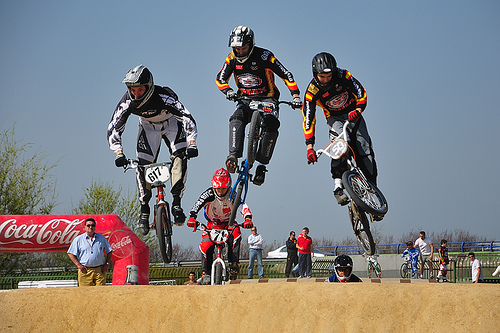

100%|██████████| 1/1 [00:01<00:00,  1.41s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 2/10:
Текст: Three riders wearing black jerseys jump their BMX bikes into the air .
Оценка: 0.2971
This image is unavailable in your country in compliance with local laws.


100%|██████████| 1/1 [00:01<00:00,  1.33s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 3/10:
Текст: A man sits on the gravel by an ocean .
Оценка: 0.4575
This image is unavailable in your country in compliance with local laws.


100%|██████████| 1/1 [00:01<00:00,  1.34s/it]


Запрос 4/10:
Текст: Four people are cavorting on the rocks at a river 's edge
Оценка: 0.2660



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


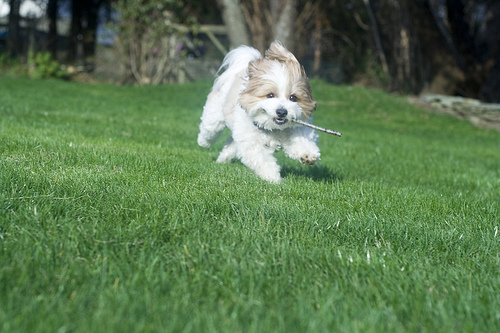

100%|██████████| 1/1 [00:01<00:00,  1.54s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 5/10:
Текст: Woman in colorful shirt works at sewing machine .
Оценка: 0.2496


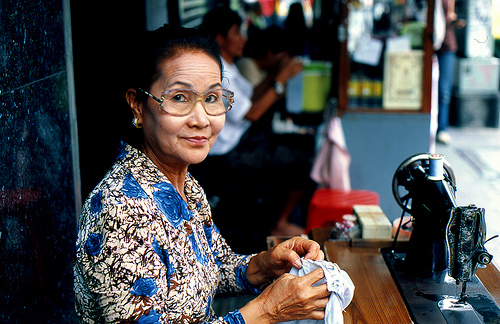

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 6/10:
Текст: The furry black and white dog is running through a shallow pool .
Оценка: 0.4564


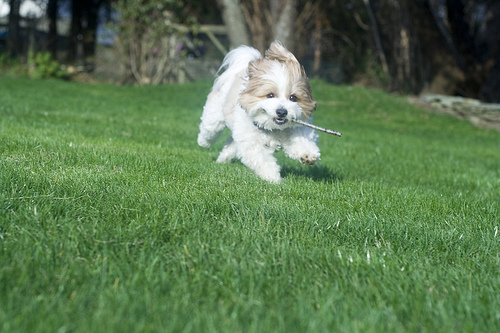

100%|██████████| 1/1 [00:01<00:00,  1.80s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 7/10:
Текст: The shoppers are walking in a store .
Оценка: 0.3198
This image is unavailable in your country in compliance with local laws.


100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 8/10:
Текст: A boy in a blue shirt and white helmet is riding a white bike .
Оценка: 0.2037
This image is unavailable in your country in compliance with local laws.


100%|██████████| 1/1 [00:01<00:00,  1.35s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 9/10:
Текст: Four people are cavorting on the rocks at a river 's edge
Оценка: 0.2660


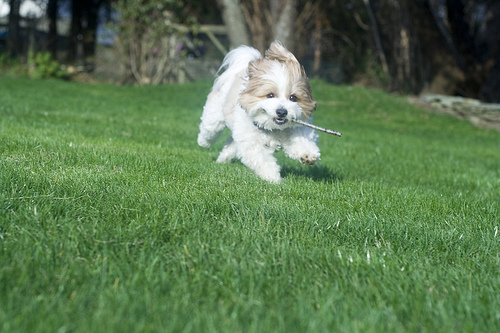

100%|██████████| 1/1 [00:01<00:00,  1.38s/it]
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



Запрос 10/10:
Текст: Two people sit on a brick wall and talk .
Оценка: 0.3201


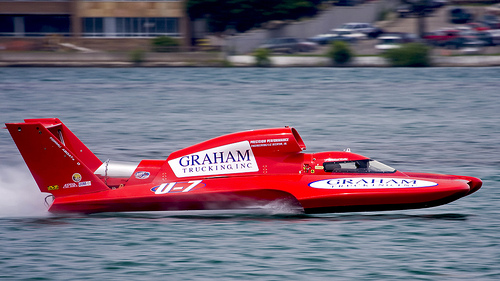

In [ ]:
for _ in range(10):

    random_idx = np.random.randint(0, len(test_queries))

    result = process_query(
        text_description=test_queries.iloc[random_idx]['query_text'],
        test_queries=test_queries,
        model_debert=model_debert,
        tokenizer=tokenizer,
        best_model=best_model,
        scaler=scaler,
        child_list=child_list,
        image_folder_test=image_folder_test
    )

    # Выводим результат
    print(f"\nЗапрос {_ + 1}/10:")
    print(f"Текст: {result['text']}")
    print(f"Оценка: {result['prediction']:.4f}")

    if 'message' in result:
        print(result['message'])
    else:
        display(result['image_data'])

Итог: как видно из предоставленного, что не во всех случаях модель правильно определила изображение. Однако в ряде случаев выбор модели вполне логичный, хоть и не совсем правильный. К примеру, она выводит смотрящих в камеру животных, когда надо было вывести смотрящих в камеру людей.  
Модель выдерживает ограничения и если в запросе указаны дети, то она изображение не выводит.

## Выводы
**В рамках работы сделано**:  
1. Выведена общая оценка соответствия картинок и описания.
2. Удалены из обучающей выборки картинки, содержащие изображения детей.
3. Векторизованы изображения и текст.
4. Сформированы и обучены несколько моделей.

**Результаты работы:**
1. Лучшей моделью при обучении стала нейронная сеть. Её метрика MAE составила около 0,22.
2. При использовании на тестовой выборке из 10 описаний часть изображений выводится ошибочно, но в ряде аспектов изображения и описания совпадают.
3. При запросе, который содержит упоминание детей, модель вместо фотографии выводит дисклеймер.

**Рекомендации:**  
Продолжить обучение модели для улучшения качества работы. Для этого может быть полезно применить аугментацию входящих данных, точнее настроить параметры модели.